# Generative Models: β-VAE

## Setting up working environment
You will need to install pytorch and import some utilities by running the following cell:

In [1]:
!pip install -q torch torchvision altair==4.2.2 seaborn tqdm scikit-learn
from utils.plotting import plot_tsne
from pathlib import Path
import tqdm

Here we have some default pathing options which vary depending on the environment you are using. You can of course change these as you please.

In [2]:
# Initialization Cell
assert WORKING_ENV in ['COLAB', 'PAPERSPACE', 'SAGEMAKER']

if WORKING_ENV == 'COLAB':
    from google.colab import drive
    %load_ext google.colab.data_table
    dl_gen_repo_path = 'dl_GEN/' # path in your gdrive to the repo
    content_path = f'/content/drive/MyDrive/{dl_gen_repo_path}' # path to gitrepo in gdrive after mounting
    data_path = './data/' # save the data locally
    drive.mount('/content/drive/') # Outputs will be saved in your google drive

elif WORKING_ENV == 'PAPERSPACE': # Using Paperspace
    # Paperspace does not properly render animated progress bars
    # Strongly recommend using the JupyterLab UI instead of theirs
    !pip install ipywidgets
    content_path = '/notebooks/'
    data_path = './data/'
    
elif WORKING_ENV == 'SAGEMAKER':
    content_path = '/home/studio-lab-user/sagemaker-studiolab-notebooks/dl/'
    data_path = f'{content_path}data/'

else:
  raise NotImplementedError()

content_path = Path(content_path)

## Introduction

We will implement two commonly used generative models:
1. A **Variational Autoencoder (VAE)**
2. A **Deep Convolutional Generative Adversarial Network (DCGAN)**

For the first part you will the MNIST dataset https://en.wikipedia.org/wiki/MNIST_database and for the second the CIFAR-10 (https://www.cs.toronto.edu/~kriz/cifar.html).

# Part 1 - Variational Autoencoder

## Part 1.1
**Task:**

a. Implement the VAE architecture with accompanying hyperparameters using a Convolutional Encoder and Decoder.

b. Design an appropriate loss function and train the model.


In [148]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

if not os.path.exists(content_path/'VAE/'):
    os.makedirs(content_path/'VAE/')

if not os.path.exists(data_path):
    os.makedirs(data_path)

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

GPU = True # Choose whether to use GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")

print(f'Using {device}')
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


Using cuda



## Part 1.1a: Implement VAE
### Hyper-parameter selection


In [247]:
# Necessary Hyperparameters 
num_epochs = 20
learning_rate = 0.002
batch_size = 128
latent_dim = 8 # Choose a value for the size of the latent space

# Additional Hyperparameters 
beta_values = [0.25, 0.5, 0.75, 1, 2]

# (Optionally) Modify transformations on input
transform_train = transforms.Compose([
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),      
])

# (Optionally) Modify the network's output for visualizing your images
def denorm(x):
    return x

### Data loading


In [248]:
train_dat = datasets.MNIST(
    data_path, train=True, download=True, transform=transform_train
)
test_dat = datasets.MNIST(data_path, train=False, transform=transform_test)

loader_train = DataLoader(train_dat, batch_size, shuffle=True)
loader_test = DataLoader(test_dat, batch_size, shuffle=False)

# Don't change 
sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[:32, :, :, :]
save_image(fixed_input, content_path/'VAE/image_original.png')

### Model Definition

<figure>
  <img src="https://blog.bayeslabs.co/assets/img/vae-gaussian.png" style="width:60%">
  <figcaption>
    Fig.1 - VAE Diagram (with a Guassian prior), taken from <a href="https://blog.bayeslabs.co/2019/06/04/All-you-need-to-know-about-Vae.html">1</a>.
  </figcaption>
</figure>


We need to define:
* The hyperparameters
* The constructor
* Encoder
* Reparametrize
* Decoder
* Forward

We will use batchnorm as well.

In [249]:
# *CODE FOR PART 1.1a IN THIS CELL*

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # Output: 16 x 28 x 28
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # Output: 32 x 14 x 14
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # Output: 64 x 7 x 7
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Output: 128 x 7 x 7
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(),  # Output: 128*7*7
            nn.Linear(128*7*7, latent_dim * 2)  # *2 for mean and log variance
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (128, 7, 7)),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: 32 x 14 x 14
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: 16 x 28 x 28
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1),  # Output: 1 x 28 x 28
            nn.Sigmoid()  # Use sigmoid to output values between 0 and 1
        )

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
    def encode(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        return mu, logvar
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
    
    def reparametrize(self, mu, logvar):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

    def decode(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        return self.decoder(z)
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
    
    def forward(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

model = VAE(latent_dim).to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Total number of parameters is: 351697
VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=6272, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=6272, bias=True)
    (1): ReLU


## Part 1.1b: Training the Model

### Defining a Loss
Recall the Beta VAE loss, with an encoder $q$ and decoder $p$:
$$ \mathcal{L}=\mathbb{E}_{q_\phi(z \mid X)}[\log p_\theta(X \mid z)]-\beta D_{K L}[q_\phi(z \mid X) \| p_\theta(z)]$$

In order to implement this loss we will need to think carefully about our model's outputs and the choice of prior.


* We will also experiment with the weighting coefficient $\beta$ and observe how it affects the training

Beta:  0.25


Epoch 2: 100%|██| 469/469 [00:05<00:00, 84.00batch/s, kl_loss=24.9, loss=93.2, recon_loss=87]
Epoch 3: 100%|█| 469/469 [00:05<00:00, 84.69batch/s, kl_loss=22.6, loss=88.8, recon_loss=83.2
Epoch 4: 100%|█| 469/469 [00:05<00:00, 84.32batch/s, kl_loss=23.1, loss=86.9, recon_loss=81.1
Epoch 5: 100%|█| 469/469 [00:05<00:00, 84.22batch/s, kl_loss=21.9, loss=81.6, recon_loss=76.1
Epoch 6: 100%|█| 469/469 [00:05<00:00, 85.43batch/s, kl_loss=25.2, loss=92.6, recon_loss=86.3
Epoch 7: 100%|██| 469/469 [00:05<00:00, 80.32batch/s, kl_loss=23.1, loss=83.8, recon_loss=78]
Epoch 8: 100%|█| 469/469 [00:05<00:00, 84.82batch/s, kl_loss=24.2, loss=87.7, recon_loss=81.7
Epoch 9: 100%|██| 469/469 [00:05<00:00, 79.02batch/s, kl_loss=24.4, loss=86, recon_loss=79.9]
Epoch 10: 100%|█| 469/469 [00:05<00:00, 83.95batch/s, kl_loss=25.2, loss=88.4, recon_loss=82.
Epoch 11: 100%|█| 469/469 [00:05<00:00, 83.83batch/s, kl_loss=24.4, loss=86.8, recon_loss=80.
Epoch 12: 100%|█| 469/469 [00:05<00:00, 85.74batch/s, kl_los

Beta:  0.5


Epoch 3: 100%|███| 469/469 [00:05<00:00, 84.35batch/s, kl_loss=20.4, loss=100, recon_loss=90]
Epoch 4: 100%|█| 469/469 [00:05<00:00, 85.35batch/s, kl_loss=19.9, loss=98.5, recon_loss=88.6
Epoch 5: 100%|██| 469/469 [00:05<00:00, 85.65batch/s, kl_loss=21.4, loss=96.7, recon_loss=86]
Epoch 6: 100%|█| 469/469 [00:05<00:00, 85.43batch/s, kl_loss=20.1, loss=94.7, recon_loss=84.7
Epoch 7: 100%|█| 469/469 [00:05<00:00, 85.21batch/s, kl_loss=19.4, loss=94.2, recon_loss=84.4
Epoch 8: 100%|█| 469/469 [00:05<00:00, 84.94batch/s, kl_loss=20.1, loss=91.1, recon_loss=81.1
Epoch 9: 100%|██| 469/469 [00:05<00:00, 84.67batch/s, kl_loss=21, loss=94.9, recon_loss=84.5]
Epoch 10: 100%|█| 469/469 [00:05<00:00, 83.94batch/s, kl_loss=20.5, loss=93.1, recon_loss=82.
Epoch 11: 100%|█| 469/469 [00:05<00:00, 84.44batch/s, kl_loss=20.7, loss=91.1, recon_loss=80.
Epoch 12: 100%|█| 469/469 [00:05<00:00, 84.24batch/s, kl_loss=19.8, loss=93.1, recon_loss=83.
Epoch 13: 100%|█| 469/469 [00:05<00:00, 81.68batch/s, kl_los

Beta:  0.75


Epoch 9: 100%|██| 469/469 [00:05<00:00, 83.76batch/s, kl_loss=18.9, loss=99, recon_loss=84.8]
Epoch 10: 100%|█| 469/469 [00:05<00:00, 83.86batch/s, kl_loss=19.1, loss=97.6, recon_loss=83.
Epoch 11: 100%|████| 469/469 [00:05<00:00, 84.47batch/s, kl_loss=20, loss=101, recon_loss=86]
Epoch 12: 100%|█| 469/469 [00:05<00:00, 84.26batch/s, kl_loss=19.2, loss=97.9, recon_loss=83.
Epoch 13: 100%|█| 469/469 [00:05<00:00, 84.44batch/s, kl_loss=18.7, loss=97.9, recon_loss=83.
Epoch 14: 100%|█| 469/469 [00:05<00:00, 84.34batch/s, kl_loss=19.7, loss=96.5, recon_loss=81.
Epoch 15: 100%|█| 469/469 [00:05<00:00, 84.12batch/s, kl_loss=18.2, loss=96.5, recon_loss=82.
Epoch 16: 100%|█| 469/469 [00:05<00:00, 84.76batch/s, kl_loss=18.1, loss=98.3, recon_loss=84.
Epoch 17: 100%|█| 469/469 [00:05<00:00, 83.16batch/s, kl_loss=18.7, loss=94.6, recon_loss=80.
Epoch 18: 100%|█| 469/469 [00:05<00:00, 85.05batch/s, kl_loss=19.2, loss=97.3, recon_loss=82.
Epoch 19: 100%|█| 469/469 [00:05<00:00, 83.80batch/s, kl_los

Beta:  1


Epoch 10: 100%|██| 469/469 [00:05<00:00, 84.16batch/s, kl_loss=16, loss=103, recon_loss=86.5]
Epoch 11: 100%|█| 469/469 [00:05<00:00, 83.58batch/s, kl_loss=18.1, loss=106, recon_loss=88.1
Epoch 12: 100%|█| 469/469 [00:05<00:00, 81.27batch/s, kl_loss=17.6, loss=103, recon_loss=85.8
Epoch 13: 100%|█| 469/469 [00:05<00:00, 84.32batch/s, kl_loss=16.7, loss=103, recon_loss=86.4
Epoch 14: 100%|█| 469/469 [00:05<00:00, 83.76batch/s, kl_loss=17.4, loss=101, recon_loss=83.7
Epoch 15: 100%|█| 469/469 [00:05<00:00, 84.19batch/s, kl_loss=17.9, loss=106, recon_loss=88.2
Epoch 16: 100%|█| 469/469 [00:05<00:00, 84.96batch/s, kl_loss=17.8, loss=100, recon_loss=82.6
Epoch 17: 100%|█| 469/469 [00:05<00:00, 87.18batch/s, kl_loss=17.9, loss=102, recon_loss=84.5
Epoch 18: 100%|█| 469/469 [00:05<00:00, 86.38batch/s, kl_loss=16.9, loss=103, recon_loss=86.2
Epoch 19: 100%|███| 469/469 [00:05<00:00, 85.92batch/s, kl_loss=17, loss=96.9, recon_loss=80]


Beta:  2


Epoch 9: 100%|███| 469/469 [00:05<00:00, 85.91batch/s, kl_loss=13, loss=114, recon_loss=88.4]
Epoch 10: 100%|█| 469/469 [00:05<00:00, 86.60batch/s, kl_loss=13.3, loss=121, recon_loss=94.7
Epoch 11: 100%|█| 469/469 [00:05<00:00, 85.58batch/s, kl_loss=13.2, loss=120, recon_loss=93.5
Epoch 12: 100%|█| 469/469 [00:05<00:00, 86.60batch/s, kl_loss=13.3, loss=119, recon_loss=92.6
Epoch 13: 100%|█| 469/469 [00:05<00:00, 86.84batch/s, kl_loss=13.7, loss=121, recon_loss=93.2
Epoch 15: 100%|██| 469/469 [00:05<00:00, 86.27batch/s, kl_loss=13.6, loss=114, recon_loss=87]
Epoch 16: 100%|█| 469/469 [00:05<00:00, 87.75batch/s, kl_loss=13.9, loss=115, recon_loss=86.8
Epoch 17: 100%|██| 469/469 [00:05<00:00, 86.80batch/s, kl_loss=14.2, loss=119, recon_loss=91]
Epoch 18: 100%|█| 469/469 [00:05<00:00, 86.28batch/s, kl_loss=13.1, loss=119, recon_loss=92.4
Epoch 19: 100%|█| 469/469 [00:05<00:00, 86.96batch/s, kl_loss=14.1, loss=121, recon_loss=92.9


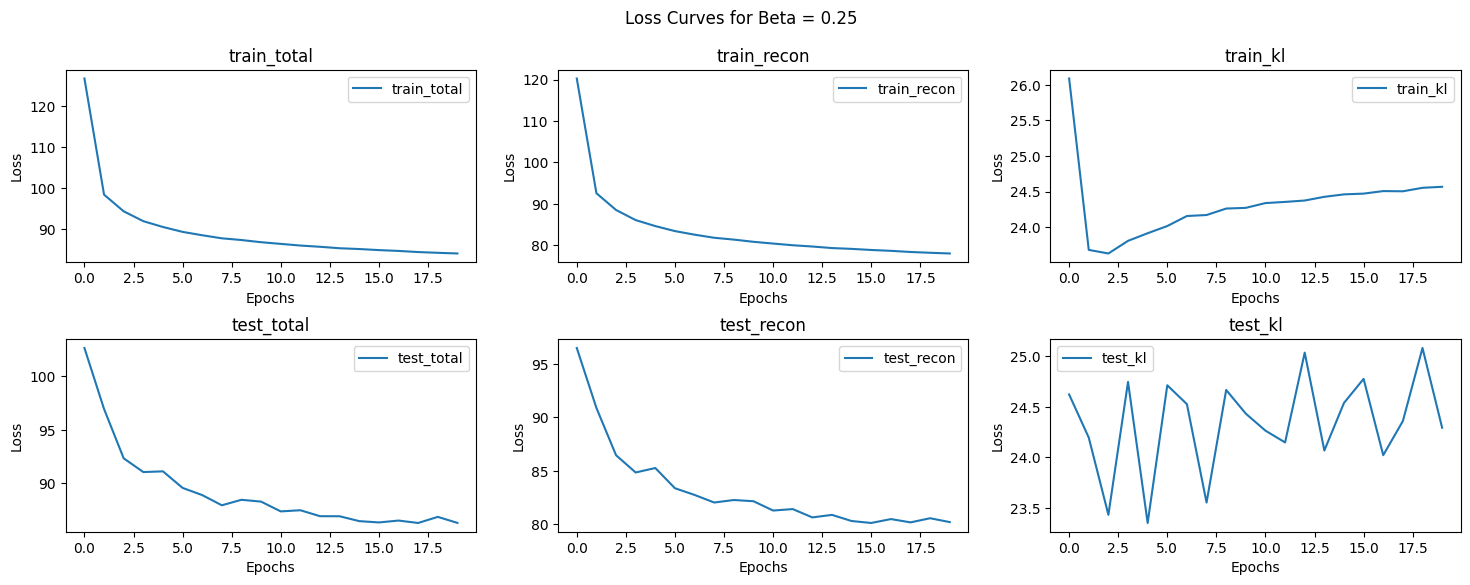

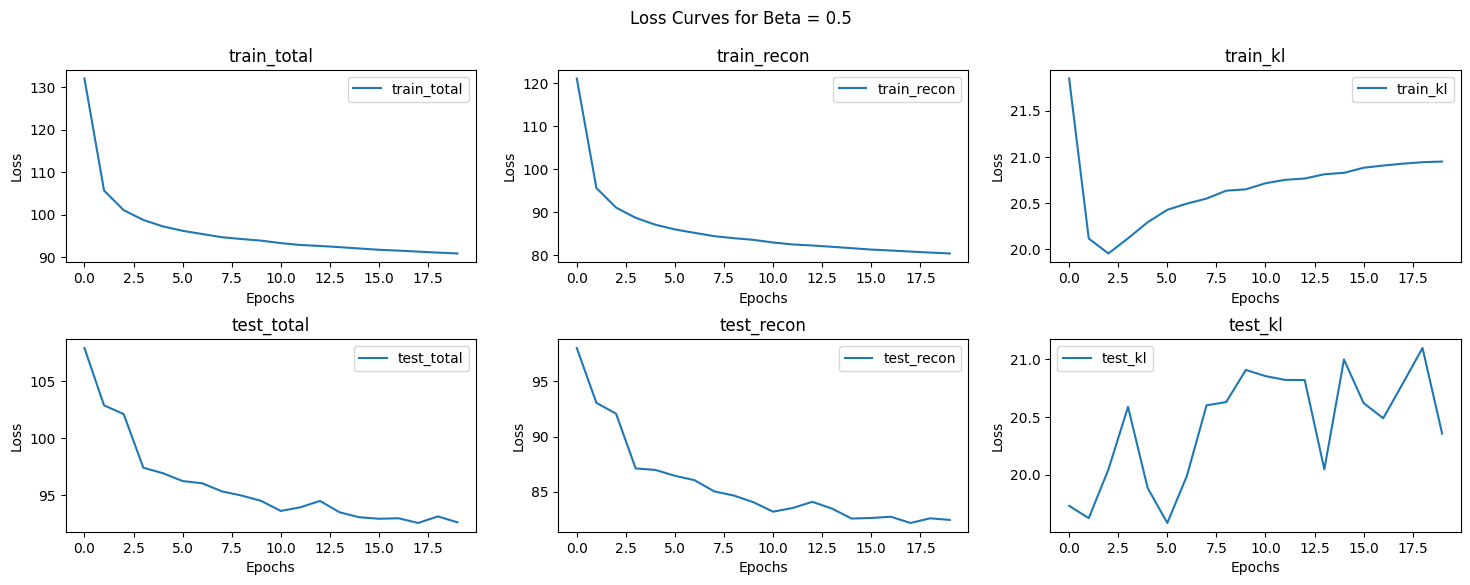

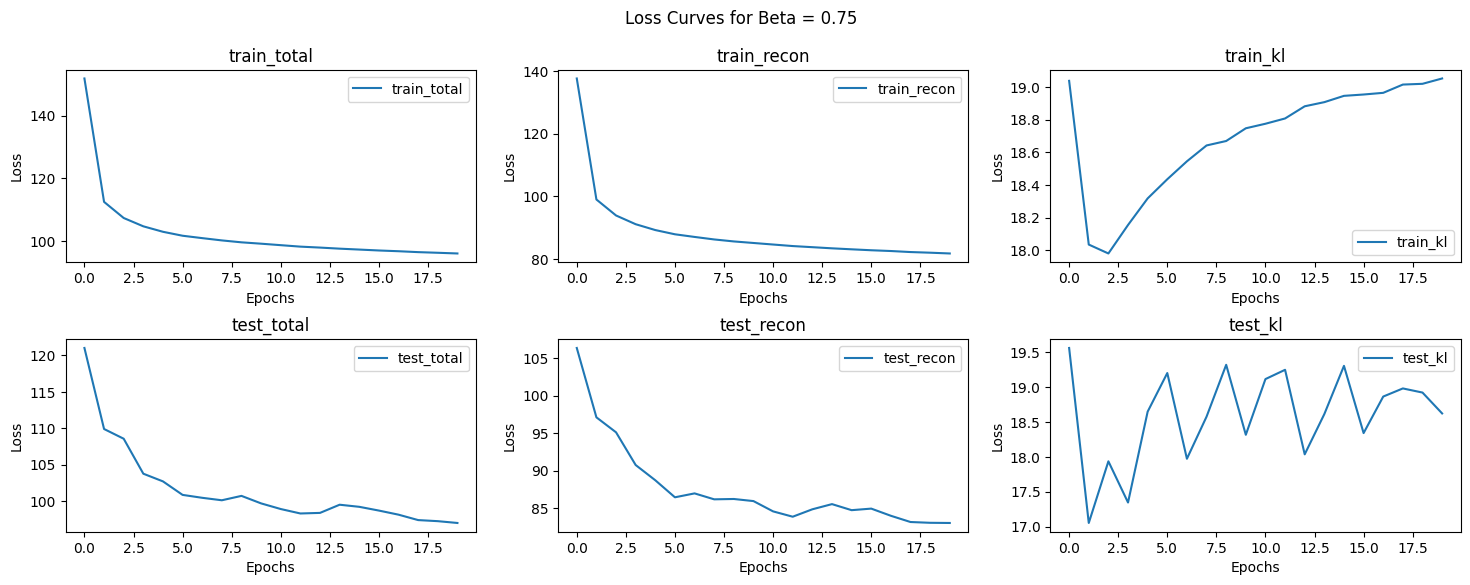

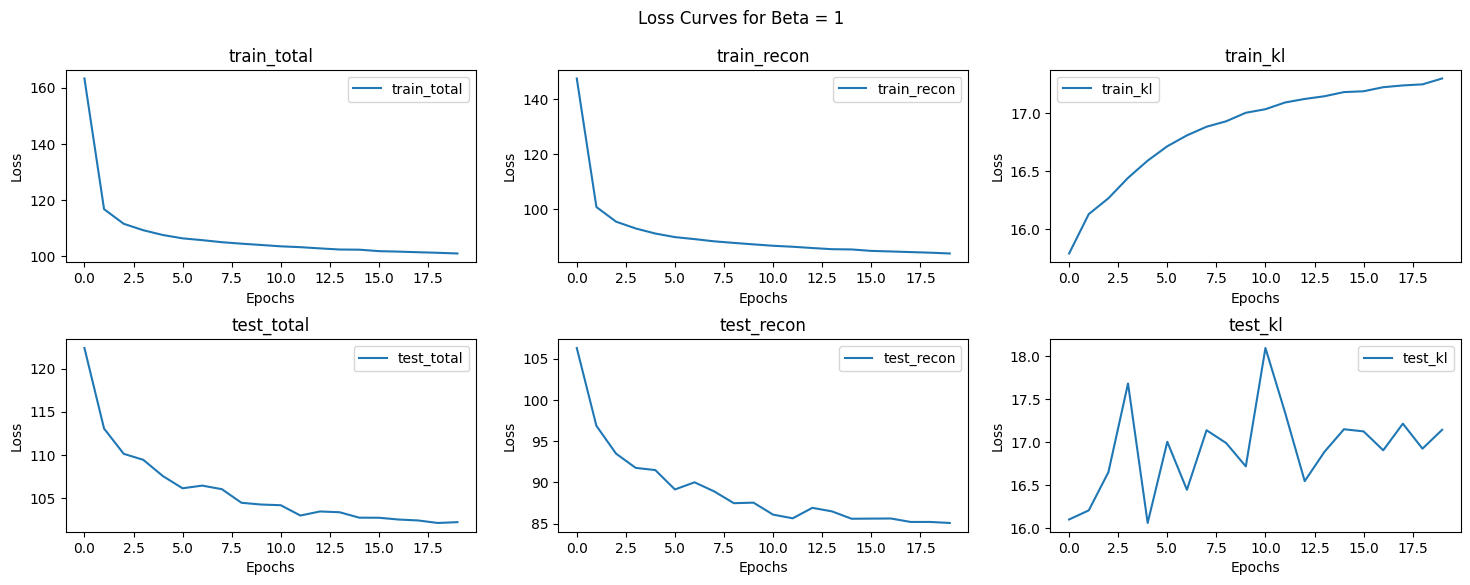

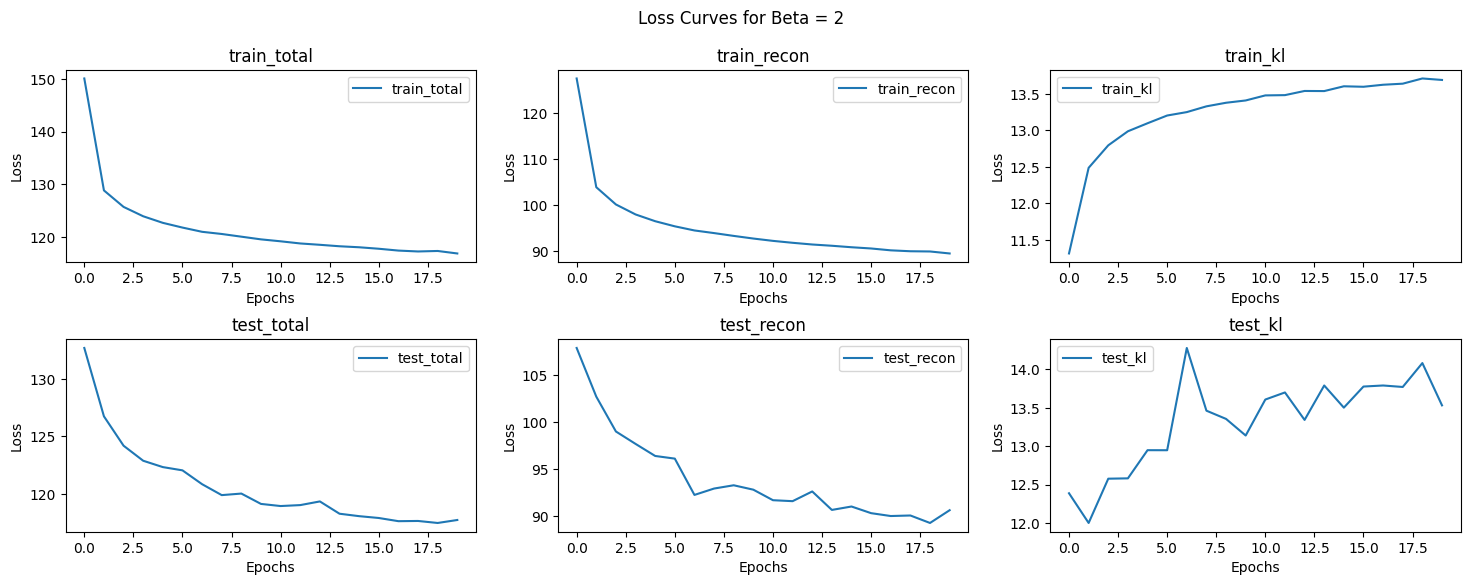

In [250]:
# *CODE FOR PART 1.1b IN THIS CELL*

def loss_function_VAE(recon_x, x, mu, logvar, beta):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        """
        Calculate the loss for Beta-VAE.
    
        Parameters:
        - recon_x: reconstructed images
        - x: original images
        - mu: mean from the latent distribution
        - logvar: log variance from the latent distribution
        - beta: weight for the KL divergence term
    
        Returns:
        - Total loss as a combination of reconstruction loss and weighted KL divergence.
        """
        # Reconstruction loss (using binary cross-entropy)
        recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    
        # KL Divergence
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
        # Beta-VAE Loss
        total_loss = recon_loss + beta * kl_div
        return total_loss, recon_loss, kl_div
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 


# Placeholder for loss tracking
losses = {beta: {'train_total': [], 'train_recon': [], 'train_kl': [], 'test_total': [], 'test_recon': [], 'test_kl': []} for beta in beta_values}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for beta in beta_values:
    print("Beta: ",beta)
    model = VAE(latent_dim).to(device)  # Reinitialize the model for each beta
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop for this beta
    for epoch in range(num_epochs):
        model.train()
        train_total_loss, train_recon_loss, train_kl_loss = 0.0, 0.0, 0.0
        with tqdm.tqdm(loader_train, unit="batch") as tepoch: 
            for batch_idx, (data, _) in enumerate(tepoch):
                ######################################################################
                #                       ** START OF YOUR CODE **
                ######################################################################
                data = data.to(device)
                optimizer.zero_grad()
                recon_batch, mu, logvar = model(data)
                loss, recon_loss, kl_div = loss_function_VAE(recon_batch, data, mu, logvar, beta)
                loss.backward()
                optimizer.step()
                train_total_loss += loss.item()
                train_recon_loss += recon_loss.item()
                train_kl_loss += kl_div.item()
                #######################################################################
                #                       ** END OF YOUR CODE **
                ####################################################################### 
                if batch_idx % 20 == 0:
                    tepoch.set_description(f"Epoch {epoch}")
                    tepoch.set_postfix(loss=loss.item()/len(data), recon_loss=recon_loss.item()/len(data), kl_loss=kl_div.item()/len(data))

        # Compute average losses and store
        losses[beta]['train_total'].append(train_total_loss / len(loader_train.dataset))
        losses[beta]['train_recon'].append(train_recon_loss / len(loader_train.dataset))
        losses[beta]['train_kl'].append(train_kl_loss / len(loader_train.dataset))

        
        # Evaluation loop for this beta
        model.eval()
        test_total_loss, test_recon_loss, test_kl_loss = 0.0, 0.0, 0.0
        with torch.no_grad():
            for data, _ in loader_test:
                data = data.to(device)
                recon_batch, mu, logvar = model(data)
                loss, recon_loss, kl_div = loss_function_VAE(recon_batch, data, mu, logvar, beta)
                test_total_loss += loss.item()
                test_recon_loss += recon_loss.item()
                test_kl_loss += kl_div.item()

        # Compute average losses and store
        losses[beta]['test_total'].append(test_total_loss / len(loader_test.dataset))
        losses[beta]['test_recon'].append(test_recon_loss / len(loader_test.dataset))
        losses[beta]['test_kl'].append(test_kl_loss / len(loader_test.dataset))


        # save the model
        if epoch == num_epochs - 1:
            with torch.no_grad():
                model_path = content_path /'VAE/'f'VAE_model_beta_{beta}.pth' 
                torch.save(model.state_dict(), model_path)

                # Save the model as a TorchScript
                model_script_path = content_path /'VAE/'f'VAE_model_script_beta_{beta}.pth'
                torch.jit.save(torch.jit.trace(model, (data), check_trace=False),
                model_script_path)


# Plotting
for beta in beta_values:
    plt.figure(figsize=(18, 6))
    plt.suptitle(f"Loss Curves for Beta = {beta}")
    for i, key in enumerate(['train_total', 'train_recon', 'train_kl', 'test_total', 'test_recon', 'test_kl'], 1):
        plt.subplot(2, 3, i)
        plt.plot(losses[beta][key], label=f"{key}")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f"{key}")
        plt.legend()
    plt.subplots_adjust(hspace=0.4)
    plt.show()


### Loss Explanation

The architecture and loss function are developed with specific goals: to reconstruct input data accurately while learning a structured and potentially disentangled latent space representation. Here's how it relates to the various aspects of a VAE:

### Design choices:
- **Data Distribution Assumptions**: In the latent space, a Gaussian distribution is chosen to model the data, with an assumption that such a distribution can effectively encapsulate the MNIST dataset's inherent variability. This choice is evident in the encoder's output, which parameterizes this Gaussian distribution through mean (μ) and log-variance (log(σ²)). The adoption of a normal distribution as the latent space's prior is motivated by the central limit theorem, suggesting that the sum of numerous independent random variables tends toward a normal distribution, irrespective of their original distributions.
- **Hyperparameter Selection:**  
Standard hyperparameters (learning rate = 0.002, batch size=128, latent dimension=8) are chosen for optimal VAE performance on MNIST. Exploring β values (0.25 to 2) seeks a trade-off between reconstruction quality and disentanglement, with higher β enhancing regularization and disentanglement at the expense of reconstruction accuracy.

### VAE Prior

The VAE is based on the probabilistic framework where the encoder learns the parameters of a probability distribution representing the data in the latent space. The loss function for a VAE typically consists of two terms:

1. **Reconstruction Loss**: This term ensures that the decoded samples closely match the original inputs, thus encouraging accurate reconstruction of the input data. For MNIST images, which are pixel values normalized between 0 and 1, a binary cross-entropy loss is suitable because it treats the reconstruction task like a series of Bernoulli trials, one for each pixel.

2. **KL Divergence**: This term acts as a regularizer, enforcing the learned distribution to be close to some prior distribution. The standard choice for the prior is a multivariate Gaussian with a diagonal covariance matrix (typically the standard normal distribution, N(0, I)). The KL divergence thus measures how much the learned distribution (encoded by the encoder) deviates from this prior.

The choice of a Gaussian prior is allows to have a continuous, differentiable, and mathematically tractable latent space. It simplifies the KL divergence calculation and encourages the encoder to map inputs to a dense region in the latent space where sampling is meaningful.

### Output Data Domain

For MNIST, the VAE's decoder aims to reconstruct grayscale images with pixel values between 0 and 1. The sigmoid activation function in the final layer of the decoder is well-suited for this task because it squashes the output to lie within this range. The reconstruction loss (binary cross-entropy) then quantifies how well the model's outputs match these bounded pixel values, treating the task as a binary classification problem for each pixel.

### Disentanglement in the Latent Space

Disentanglement refers to the latent space's ability to separate distinct, informative factors of variation in the data. In a disentangled representation, changes in one dimension of the latent space correspond to changes in one factor of variation, while being relatively invariant to changes in other factors. In my VAE, the loss function's design, combining reconstruction loss with KL divergence, directly influences disentanglement in the latent space. The reconstruction loss ensures accurate data representation, while the KL term encourages the latent variables to align with the Gaussian prior, promoting disentangled representations. Adjusting the weight of the KL term allows me to control the extent of disentanglement.

### Influence of Beta
The KL divergence term encourages disentanglement by penalizing complex, entangled representations that deviate significantly from the prior. When the β parameter (which weighs the KL divergence term) is increased, the model is more heavily penalized for representations that are not aligned with the prior, thus promoting disentangled representations. However, if β is too high, the model may underfit and fail to capture important aspects of the data, leading to poor reconstruction.


<h2>Part 1.2</h2>

a. Plotting loss curves
b. Showing reconstructions and samples

## Part 1.2a: Loss Curves

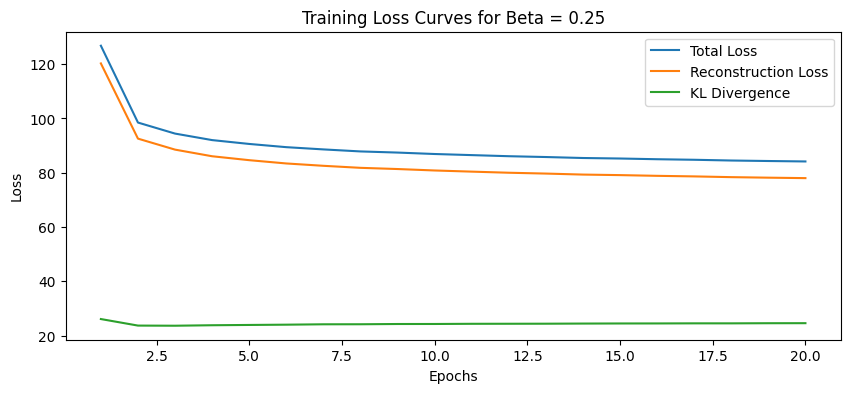

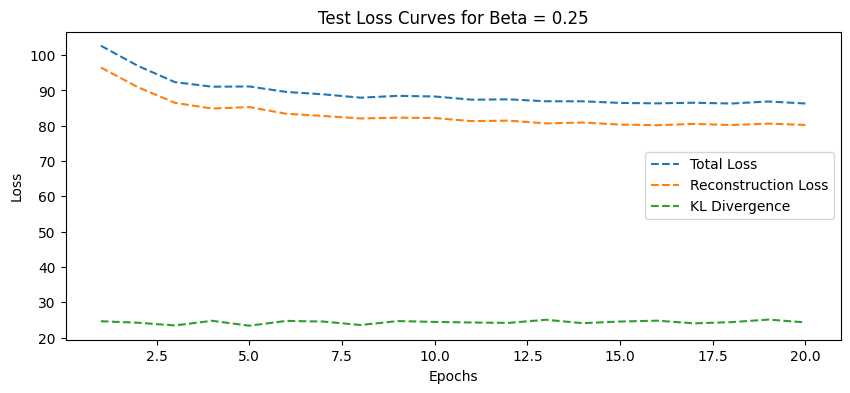

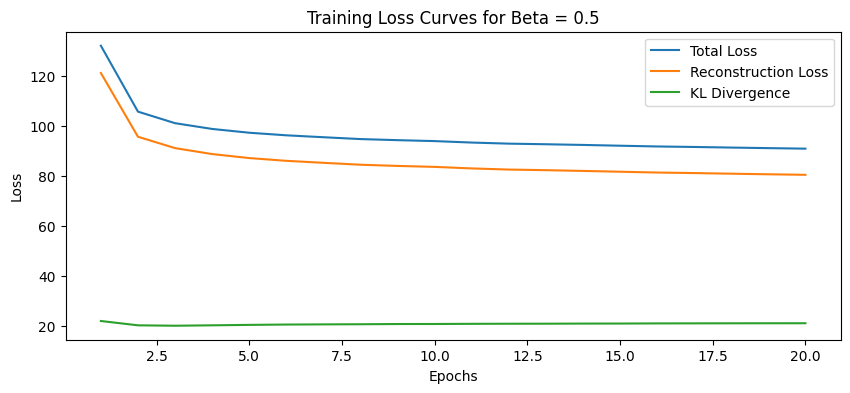

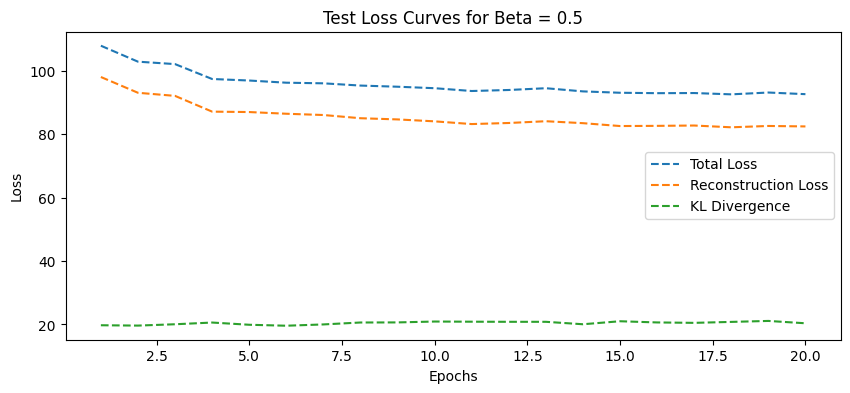

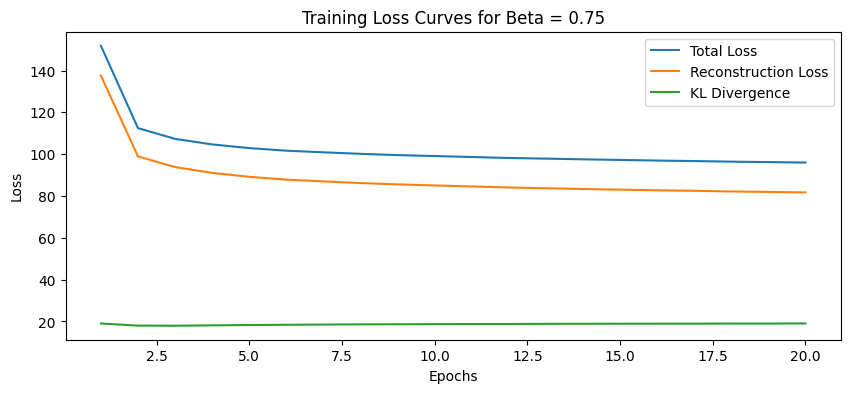

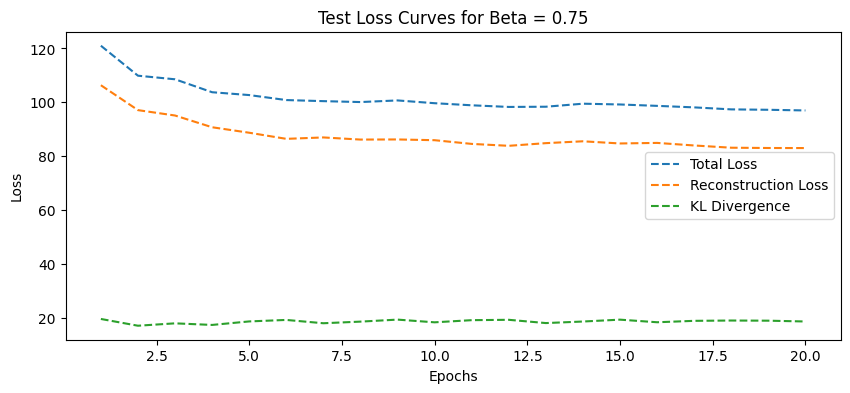

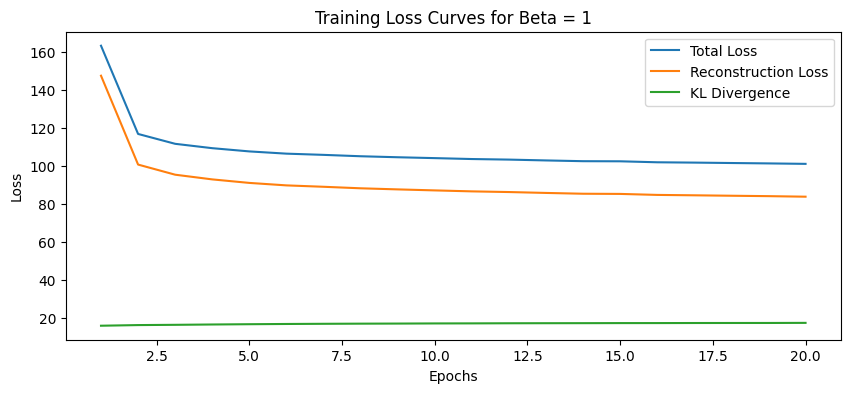

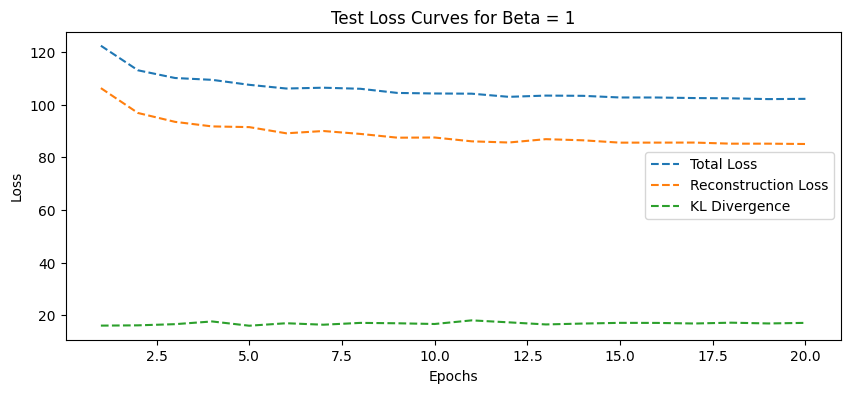

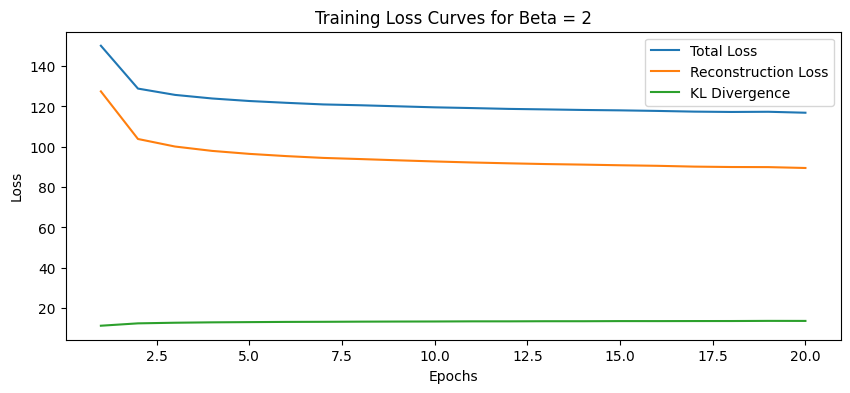

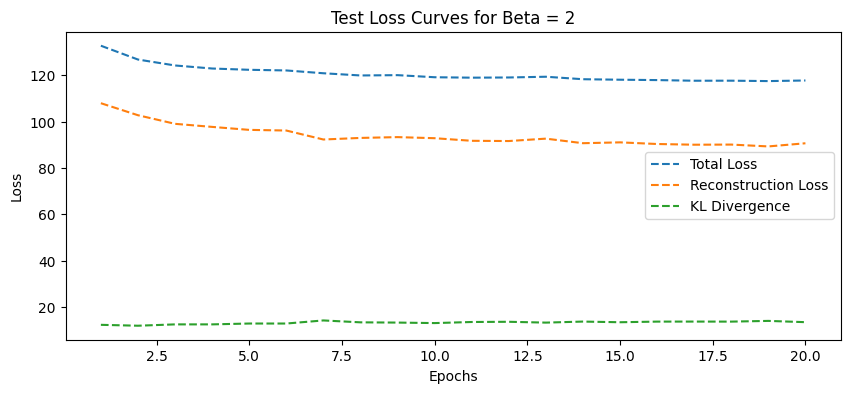

In [251]:
# *CODE FOR PART 1.2a IN THIS CELL*
for beta in beta_values:
    epochs_range = range(1, len(losses[beta]['train_total']) + 1)
    
    # Plot for training losses
    plt.figure(figsize=(10, 4))
    plt.title(f"Training Loss Curves for Beta = {beta}")
    plt.plot(epochs_range, losses[beta]['train_total'], label='Total Loss')
    plt.plot(epochs_range, losses[beta]['train_recon'], label='Reconstruction Loss')
    plt.plot(epochs_range, losses[beta]['train_kl'], label='KL Divergence')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot for test losses
    plt.figure(figsize=(10, 4))
    plt.title(f"Test Loss Curves for Beta = {beta}")
    plt.plot(epochs_range, losses[beta]['test_total'], label='Total Loss', linestyle='--')
    plt.plot(epochs_range, losses[beta]['test_recon'], label='Reconstruction Loss', linestyle='--')
    plt.plot(epochs_range, losses[beta]['test_kl'], label='KL Divergence', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## Part 1.2b: Samples and Reconstructions
Visualizing a subset of the images of the test set and their reconstructions **as well as** a few generated samples.

Input images for Beta = 0.25
--------------------------------------------------


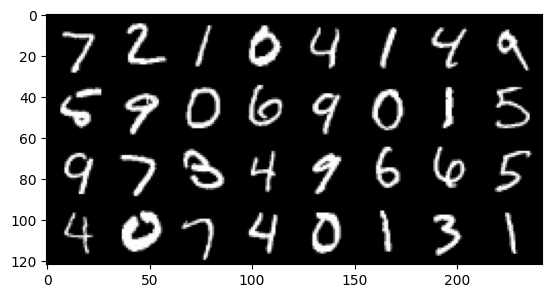

Reconstructed images for Beta = 0.25
--------------------------------------------------


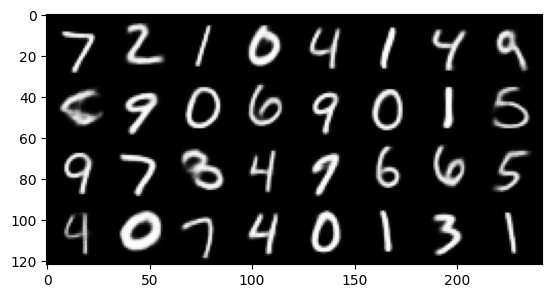

Generated Images for Beta = 0.25
--------------------------------------------------


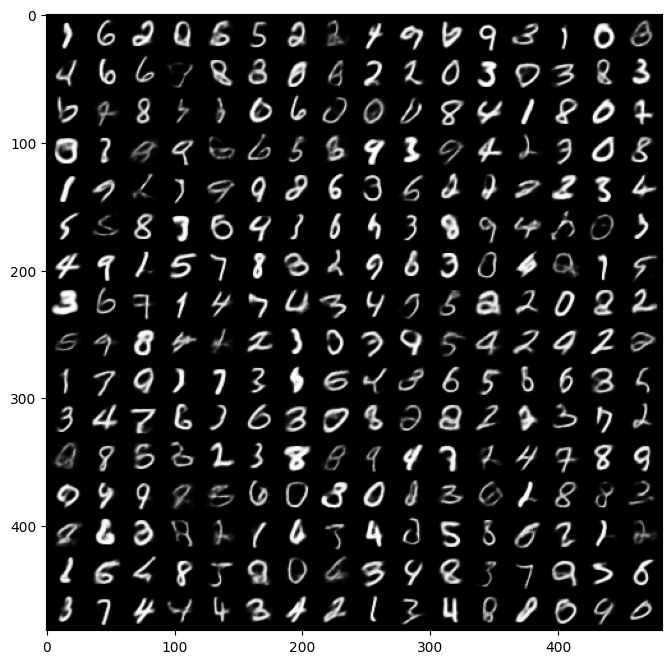

Input images for Beta = 0.5
--------------------------------------------------


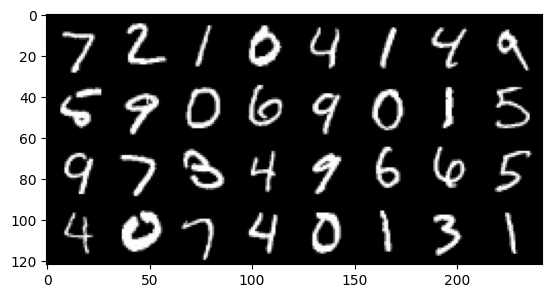

Reconstructed images for Beta = 0.5
--------------------------------------------------


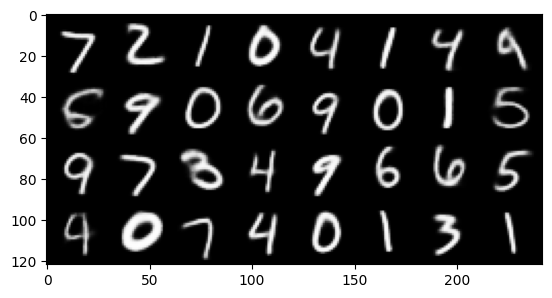

Generated Images for Beta = 0.5
--------------------------------------------------


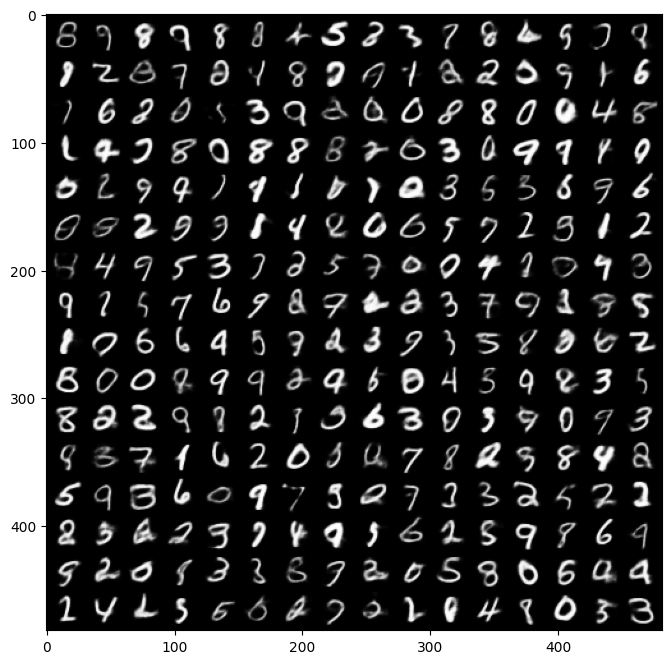

Input images for Beta = 0.75
--------------------------------------------------


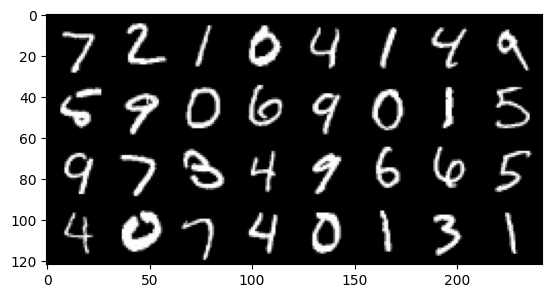

Reconstructed images for Beta = 0.75
--------------------------------------------------


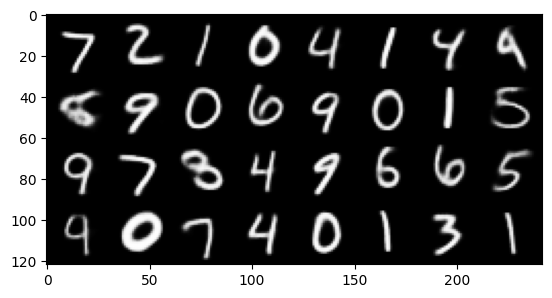

Generated Images for Beta = 0.75
--------------------------------------------------


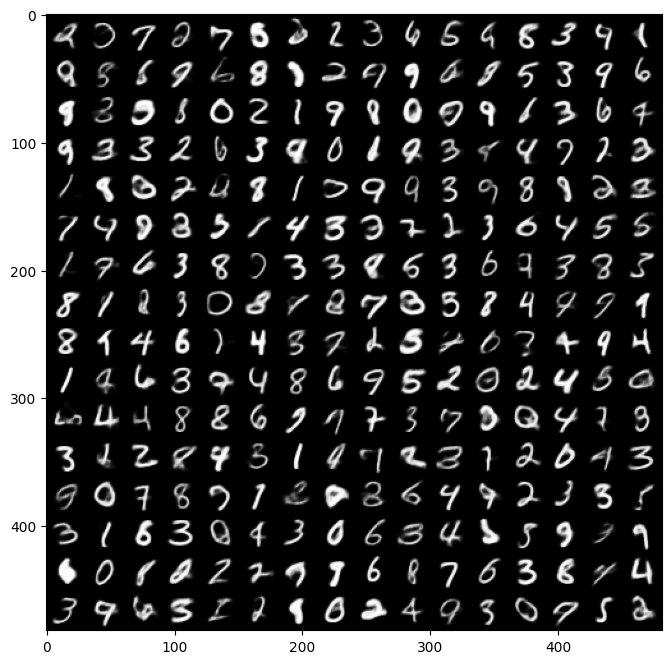

Input images for Beta = 1
--------------------------------------------------


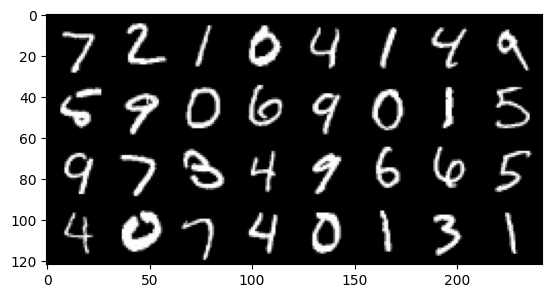

Reconstructed images for Beta = 1
--------------------------------------------------


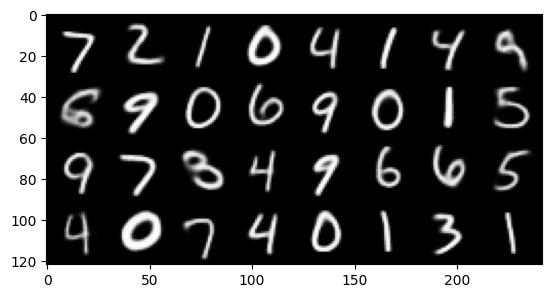

Generated Images for Beta = 1
--------------------------------------------------


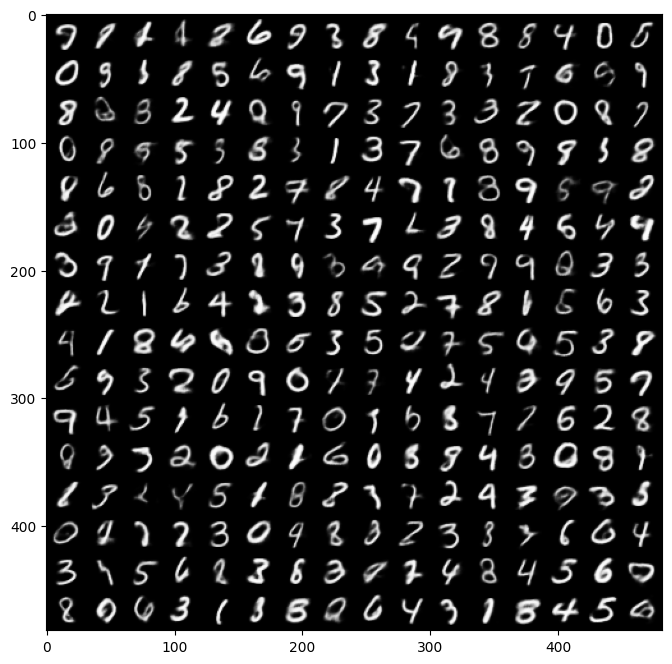

Input images for Beta = 2
--------------------------------------------------


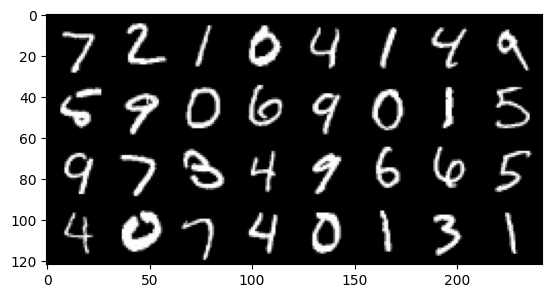

Reconstructed images for Beta = 2
--------------------------------------------------


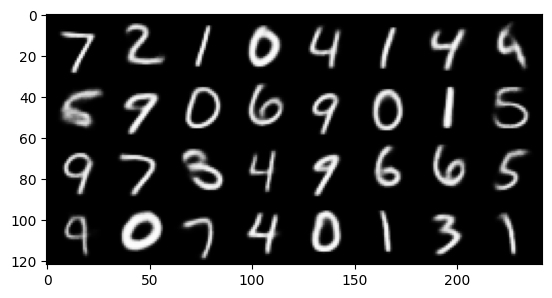

Generated Images for Beta = 2
--------------------------------------------------


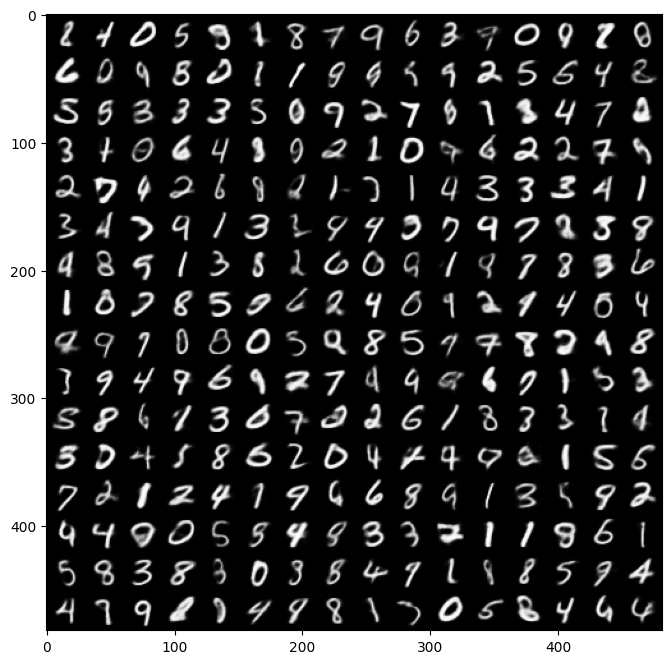

In [252]:
# *CODE FOR PART 1.2b IN THIS CELL*
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torchvision.utils import make_grid


for beta in beta_values:
    model_path = content_path /'VAE/'f'VAE_model_beta_{beta}.pth'
    # Saving the model

    model = VAE(latent_dim).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # load the model
    print(f'Input images for Beta = {beta}')
    print('-'*50)
    
    sample_inputs, _ = next(iter(loader_test))
    fixed_input = sample_inputs[0:32, :, :, :]
    # visualize the original images of the last batch of the test set
    img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                    value_range=None, scale_each=False, pad_value=0)
    plt.figure()
    show(img)
    plt.show()
    
    print(f'Reconstructed images for Beta = {beta}')
    print('-'*50)
    with torch.no_grad():
        # visualize the reconstructed images of the last batch of test set
        
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        recon_batch, _, _ = model(fixed_input.to(device))
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
        recon_batch = recon_batch.cpu()
        recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
                                value_range=None, scale_each=False, pad_value=0)
        plt.figure()
        show(recon_batch)
        plt.show()
    
    print(f'Generated Images for Beta = {beta}')  
    print('-'*50)
    model.eval()
    n_samples = 256
    z = torch.randn(n_samples,latent_dim).to(device)
    with torch.no_grad():
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        samples = model.decode(z).cpu()
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
        samples = samples.cpu()
        samples = make_grid(denorm(samples), nrow=16, padding=2, normalize=False,
                                value_range=None, scale_each=False, pad_value=0)
        plt.figure(figsize = (8,8))
        show(samples)
        plt.show()



### Discussion
A brief analysis of the loss curves and reconstructions: 

In the above loss curves, we observe distinct behaviors for the log-likelihood (reconstruction) loss and the KL divergence:

- **Log-Likelihood Loss**: Across all beta values, the reconstruction loss decreases significantly at the start of training, which is expected as the VAE learns to reconstruct input data. As training progresses, the reconstruction loss tends to plateau, suggesting the model is achieving as much fidelity in reconstruction as it can, given the architecture and the constraints of the latent space.

- **KL Divergence**: The KL loss initially decreases as the model aligns its latent space with the prior distribution, then increases, indicating a trade-off between reconstruction and regularization. Lower beta allows for more deviation from the prior, improving reconstruction, while higher beta enforces stronger regularization, potentially sacrificing reconstruction quality for a more structured latent space. This behavior balances the VAE's objectives, avoiding posterior collapse and enabling distinct latent representations.

**Desirability of the Behavior**:
- The observed behavior is generally desirable up to a point. We want the reconstruction loss to be low because it means the VAE is accurately reconstructing the input data. A stable, non-zero KL divergence is also desired, it suggests that the model maintains a balance between matching the latent space to the prior distribution (regularization) and reconstructing the input data (fidelity).

**Posterior Collapse**:
- Posterior collapse occurs when the KL divergence becomes very small or zeroes out early in training. This suggests that the latent variables are being ignored, and the decoder is likely learning to reconstruct the data without effectively using the encoded representations, which is not desirable.

**Reason for No Posterior Collapse**:
- No posterior collapse was observed during the training for different values of beta, it could be due to:
  -  The KL divergence does not approach zero for any beta value. Instead, it stabilizes, suggesting the latent space is being utilized effectively.
  - A well-balanced β that ensures the KL divergence is given enough weight to prevent the latent space from being ignored.
  - An effective architecture and training regime that allows the model to learn meaningful latent variables without overpowering the reconstruction loss.
    
When comparing the performance across the five different values of β (0.25, 0.5, 0.75, 1, and 2) based on their respective loss curves, following findings can be deduced:

**Comparative Performance Analysis:**
1. **β = 0.25 to 1**:
   - For β values ranging from 0.25 to 1, the model's behavior shifts progressively from prioritizing reconstruction towards balancing reconstruction and regularization. The quality of reconstruction remains relatively high for lower β values, indicating a focus on accurately capturing the input data's details.
   - As β approaches 1, we observe a balanced emphasis between the reconstruction fidelity and regularization of the latent space. This balance is crucial for ensuring that the model can generalize well to unseen data while retaining interpretability in the latent space.

2. **β = 2**:
   - For β = 2, the significant emphasis on the KL divergence term, intended to enforce a structured latent space, leads to a little compromise in the reconstruction quality. The observed blurriness and indistinct features in both reconstructed and generated images suggest that the model is slightly over regularized (as compared to beta = 1), impacting its ability to capture and recreate the nuances of the input data as visible in the reconstructed image.
   - This behavior indicates that while aiming for a more interpretable latent space, the model's capability to reconstruct and generate distinct images is diminished. Such a trade-off highlights the challenge of selecting an optimal β value that aligns with the desired outcome of the model, balancing between reconstruction quality and latent space interpretability.

**Findings:**
- The performance across different β values displays the inherent trade-off in VAEs between reconstruction quality and regularization of the latent space. For applications demanding high reconstruction accuracy, lower β values are preferable. Conversely, applications valuing the interpretability and structure of the latent space may benefit from higher β values, albeit at the potential cost of reconstruction quality.
- The loss curves and visual inspection of the images for β = 2 emphasize the consequences of prioritizing the latent space's structure over reconstruction. It serves as a cautionary note on the need to carefully tune β in accordance with the specific objectives and constraints of the task at hand.

In summary, the observed decrease and subsequent stabilization of both losses are signs of a well-functioning VAE under normal conditions. The reason posterior collapse didn't occur is most likely because the chosen β value and model setup effectively balanced the trade-off between the VAE's two primary objectives.


<h2> Part 1.3 </h2>

Qualitative analysis of the learned representations

a. Dimensionality Reduction of learned embeddings

b. Interpolating in the latent space

## Part 1.3a: T-SNE on Embeddings
Extract the latent representations of the test set and visualize them using [T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)  [(see implementation)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). You can use a T-SNE implementation from a library such as scikit-learn. 


## Beta = 0.25


In [ ]:
# Interactive Visualization - Code Provided
from sklearn.manifold import TSNE
import numpy as np

test_dataloader = DataLoader(test_dat, 10000, shuffle=False)
features, labels = next(iter(test_dataloader))

beta = beta_values[0]
model_path = content_path /'VAE/'f'VAE_model_beta_{beta}.pth'

# Initialize and load the model
model = VAE(latent_dim).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

with torch.no_grad():
    mu, logvar = model.encode(features.to(device))
    z = model.reparametrize(mu, logvar)  

# t-SNE Transformation
tsne = TSNE(n_components=2, random_state=33)
z_embedded = tsne.fit_transform(z.cpu().numpy())

# Plotting
""" Inputs to the function are
        z_embedded - Embedded X, Y positions for every point in test_dataloader
        test_dataloader - dataloader with batchsize set to 10000
        num_points - number of points plotted (will slow down with >1k)
"""
plot_tsne(z_embedded, test_dataloader, num_points=1000, darkmode=False)

## Beta = 0.5

In [ ]:
beta = beta_values[1]
model_path = content_path /'VAE/'f'VAE_model_beta_{beta}.pth'

# Initialize and load the model
model = VAE(latent_dim).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

with torch.no_grad():
    mu, logvar = model.encode(features.to(device))
    z = model.reparametrize(mu, logvar)  

# t-SNE Transformation
tsne = TSNE(n_components=2, random_state=33)
z_embedded = tsne.fit_transform(z.cpu().numpy())

# Plotting
""" Inputs to the function are
        z_embedded - Embedded X, Y positions for every point in test_dataloader
        test_dataloader - dataloader with batchsize set to 10000
        num_points - number of points plotted (will slow down with >1k)
"""
plot_tsne(z_embedded, test_dataloader, num_points=1000, darkmode=False)

## Beta = 0.75

In [ ]:
beta = beta_values[2]
model_path = content_path /'VAE/'f'VAE_model_beta_{beta}.pth'

# Initialize and load the model
model = VAE(latent_dim).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

with torch.no_grad():
    mu, logvar = model.encode(features.to(device))
    z = model.reparametrize(mu, logvar)  
# t-SNE Transformation
tsne = TSNE(n_components=2, random_state=33)
z_embedded = tsne.fit_transform(z.cpu().numpy())

# Plotting
""" Inputs to the function are
        z_embedded - Embedded X, Y positions for every point in test_dataloader
        test_dataloader - dataloader with batchsize set to 10000
        num_points - number of points plotted (will slow down with >1k)
"""
plot_tsne(z_embedded, test_dataloader, num_points=1000, darkmode=False)

## Beta = 1

In [ ]:
beta = beta_values[3]
model_path = content_path /'VAE/'f'VAE_model_beta_{beta}.pth'

# Initialize and load the model
model = VAE(latent_dim).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

with torch.no_grad():
    mu, logvar = model.encode(features.to(device))
    z = model.reparametrize(mu, logvar)  

# t-SNE Transformation
tsne = TSNE(n_components=2, random_state=33)
z_embedded = tsne.fit_transform(z.cpu().numpy())

# Plotting
""" Inputs to the function are
        z_embedded - Embedded X, Y positions for every point in test_dataloader
        test_dataloader - dataloader with batchsize set to 10000
        num_points - number of points plotted (will slow down with >1k)
"""
plot_tsne(z_embedded, test_dataloader, num_points=1000, darkmode=False)

## Beta = 2


In [ ]:
beta = beta_values[4]
model_path = content_path /'VAE/'f'VAE_model_beta_{beta}.pth'

# Initialize and load the model
model = VAE(latent_dim).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

with torch.no_grad():
    mu, logvar = model.encode(features.to(device))
    z = model.reparametrize(mu, logvar) 

# t-SNE Transformation
tsne = TSNE(n_components=2, random_state=33)
z_embedded = tsne.fit_transform(z.cpu().numpy())

# Plotting
""" Inputs to the function are
        z_embedded - Embedded X, Y positions for every point in test_dataloader
        test_dataloader - dataloader with batchsize set to 10000
        num_points - number of points plotted (will slow down with >1k)
"""
plot_tsne(z_embedded, test_dataloader, num_points=1000, darkmode=False)

/tmp/ipykernel_3121122/2389608079.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(colors, 10)  # Ensure you have 10 classes, adjust if your dataset is different


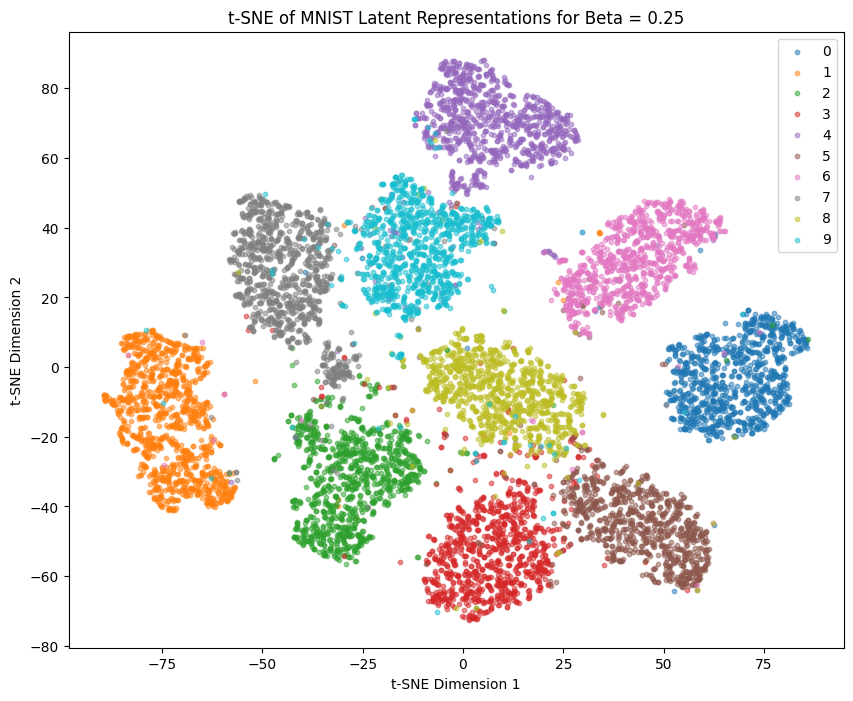

/tmp/ipykernel_3121122/2389608079.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(colors, 10)  # Ensure you have 10 classes, adjust if your dataset is different


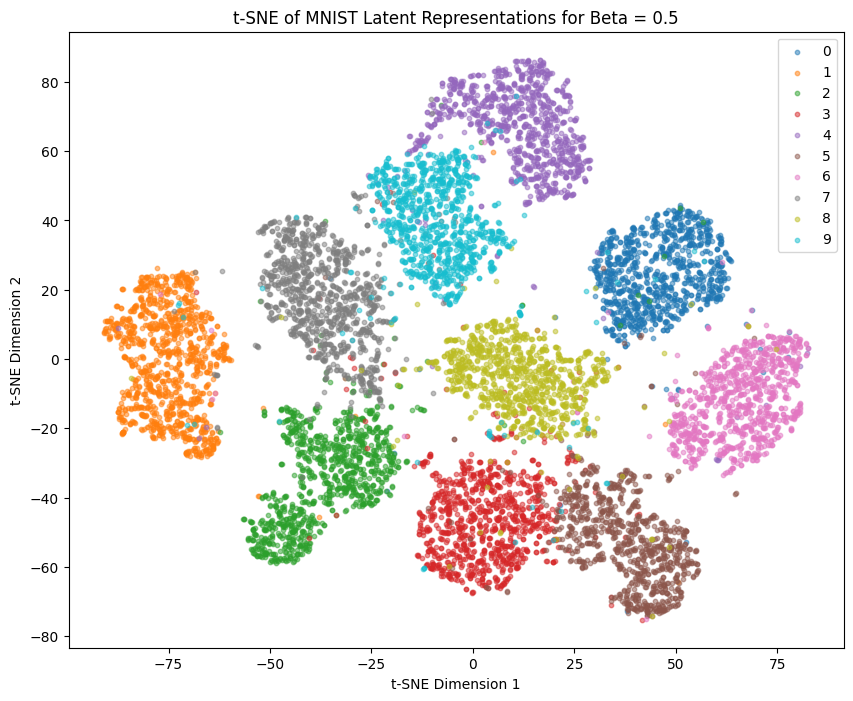

/tmp/ipykernel_3121122/2389608079.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(colors, 10)  # Ensure you have 10 classes, adjust if your dataset is different


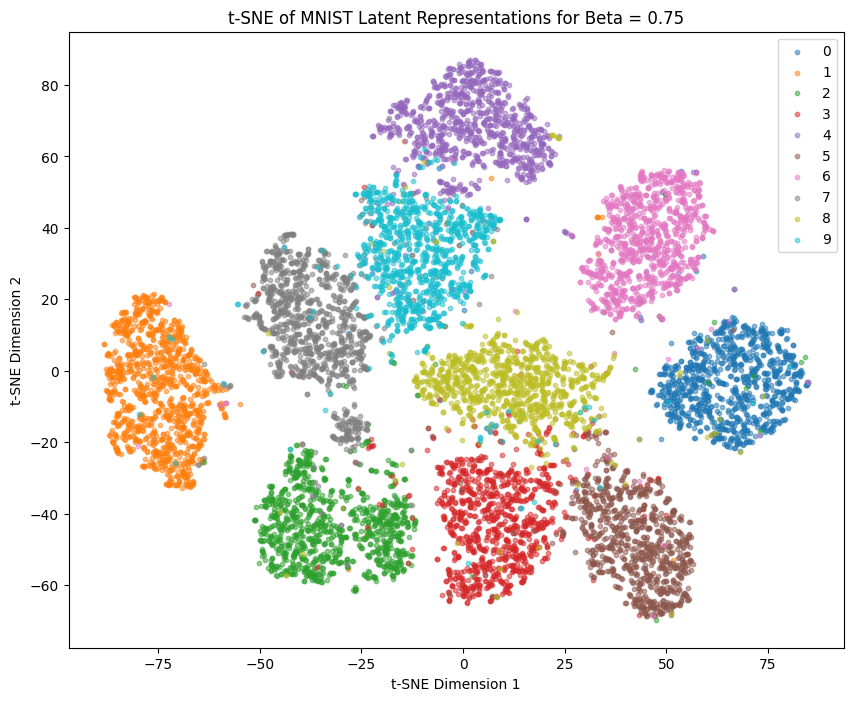

/tmp/ipykernel_3121122/2389608079.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(colors, 10)  # Ensure you have 10 classes, adjust if your dataset is different


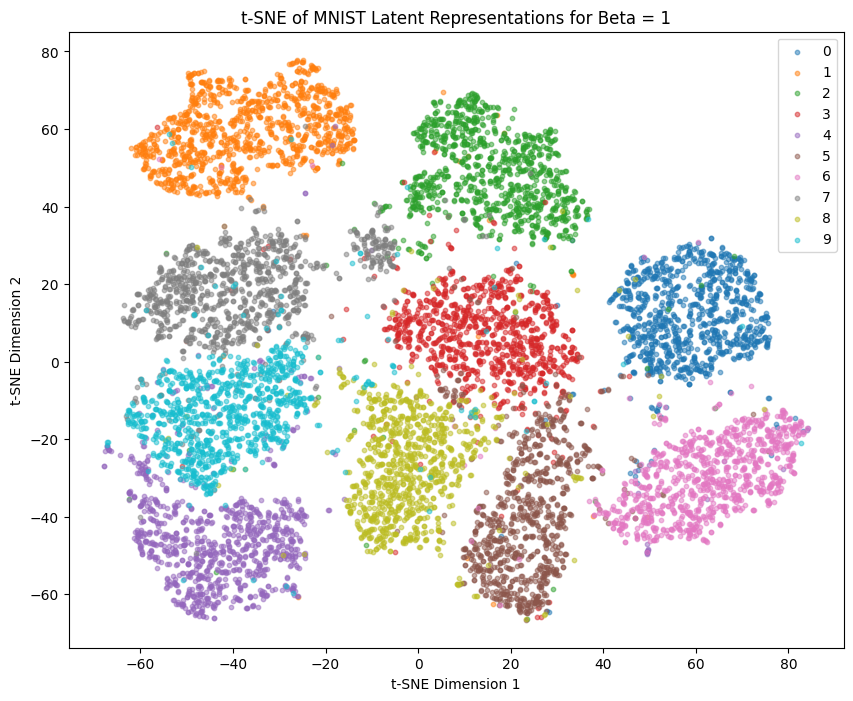

/tmp/ipykernel_3121122/2389608079.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(colors, 10)  # Ensure you have 10 classes, adjust if your dataset is different


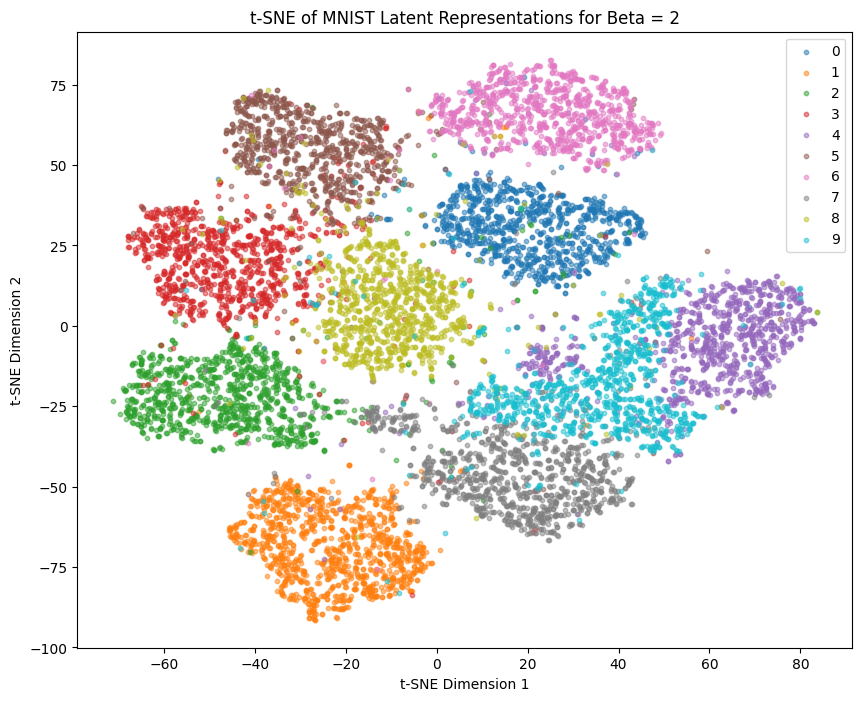

In [258]:
# Custom Visualizations

test_dataloader = DataLoader(test_dat, batch_size=10000, shuffle=False)
features, labels = next(iter(test_dataloader))
labels_numpy = labels.numpy()

for beta in beta_values:
    model_path = content_path /'VAE/'f'VAE_model_beta_{beta}.pth'
    
    # Load the model for the current beta
    model = VAE(latent_dim).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    with torch.no_grad():
        mu, logvar = model.encode(features.to(device))
        z = model.reparametrize(mu, logvar) 
    
    # Compute t-SNE embedding
    tsne = TSNE(n_components=2, random_state=33)
    z_embedded = tsne.fit_transform(z.cpu().numpy())

    # Plotting
    plt.figure(figsize=(10, 8))
    colors = 'tab10'
    cmap = plt.cm.get_cmap(colors, 10)  
    for i in range(10):  # 10 classes for MNIST
        idx = labels_numpy == i
        plt.scatter(z_embedded[idx, 0], z_embedded[idx, 1], label=i, color=cmap(i), s=10, alpha=0.5)
    
    plt.legend()
    plt.title(f't-SNE of MNIST Latent Representations for Beta = {beta}')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()



### Discussion

The role of the KL loss term and the weight coefficient β significantly influences the structure of the latent space learned by the VAE.

1. **Role of the KL Loss Term**:
   - **For β = 0.25**: The t-SNE visualization for β = 0.25 shows distinct clusters corresponding to the different digit classes in the MNIST dataset. Each cluster appears to be well-separated from the others, indicating that the VAE with this β value has learned to encode distinct features for each digit class into the latent space. This separation supports the idea that the model focuses more on reconstruction quality over regularization of the latent space due to the lower weight on the KL divergence.

   
<table><tr>
<td> 
<p align="center">
<img src="beta_0.25.png" width="500px">
<br>
<em style="color: grey">Beta 0.25</em>
</p> 
</td>
</tr></table>

   - **As β increases**: The clusters start to move closer together, and the separation between them becomes less distinct. This behavior suggests that increasing β forces the model to prioritize the KL divergence term, which encourages the latent space to adhere more closely to the prior distribution. As a result, the distinctiveness of the clusters is sacrificed to ensure that the latent space variables are more regularized and less overfit to the training data.


<table><tr>
<td> 
  <p align="center">
    <img src="beta_0.5.png" width="%30">
    <br>
    <em style="color: grey">Beta 0.5</em>
  </p> 
</td>
<td> 
  <p align="center">
    <img src="beta_0.75.png" width="%30">
    <br>
    <em style="color: grey">Beta 0.75</em>
  </p> 
</td>
<td> 
  <p align="center">
    <img src="beta_1.png" width="%30">
    <br>
    <em style="color: grey">Beta 1</em>
  </p> 
</td>
</tr></table>

   - **For β = 2**: The t-SNE visualization for β = 2 presents a different scenario than that for β = 0.25. Here, the clusters corresponding to the different digit classes are less distinct and more interspersed. This is indicative of a latent space that is highly regularized, which is a consequence of the higher β value emphasizing the KL divergence term in the VAE loss function. This regularization encourages the latent variables to conform more closely to the prior distribution, which can result in a loss of specificity for certain features that distinguish one digit from another. Consequently, this leads to a latent space where variations between different digit representations are less pronounced, making it harder to separate distinct clusters cleanly in the t-SNE plot.


<table><tr>
    <td> 
      <p align="center">
        <img src="beta_2.png" width="500px">
        <br>
        <em style="color: grey">Beta 2</em>
      </p> 
    </td>
    </tr></table>



3. **Outliers**:
    - Outliers are more prevalent when β is lower because the model is not as constrained by the prior and can capture more unique features of the data.
    - As β increases, the model becomes more regularized, and outliers are reduced because the latent representations are encouraged to adhere to the prior, leading to fewer deviations in the encoded space.

4. **Boundaries**:
    - With a lower β, the boundaries between clusters are clearer, reflecting a model that is effectively discriminating between different classes in the latent space.
    - Higher β values lead to blurred boundaries, as the emphasis on the KL term causes the model to prioritize the overall structure of the latent space over the distinction between individual classes.

5. **Clusters**:
    - The compactness and distinct separation of clusters with lower β values suggest that the model is capturing a diverse range of features from the data, which is desirable for reconstructing varied and detailed outputs.
    - As β increases, clusters become less compact and more interspersed, reflecting a latent space that is more concerned with general structure and less with capturing specific details of each class.


**Reliability of T-SNE**:
- T-SNE is a powerful tool for visualizing high-dimensional data, but it has its limitations and can sometimes produce misleading results. The visualization can be highly sensitive to its hyperparameters like perplexity and learning rate.
- T-SNE tends to expand dense clusters and contract sparse ones, which can sometimes give an incorrect impression of the true data distribution.
- If the parameters are changed, the structure of the visualized representations may change significantly. It's important to experiment with different parameters and consider multiple runs to get a more reliable understanding of the latent space structure.ple runs to get a more reliable understanding of the latent space structure.y. It's important to experiment with different parameters and consider multi

## Part 1.3b: Interpolating in $z$
Performing a linear interpolation in the latent space of the autoencoder by choosing any two digits from the test set.

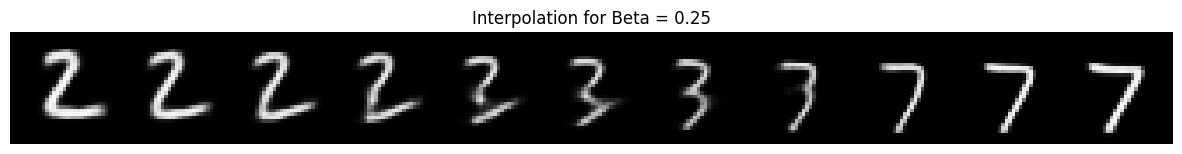

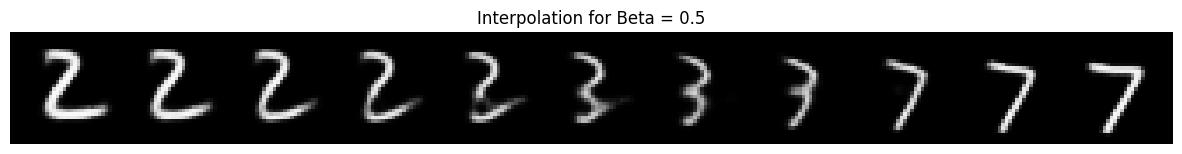

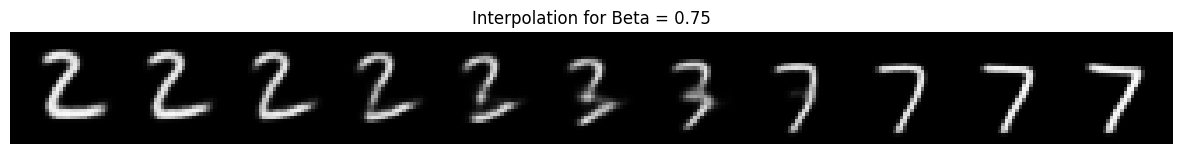

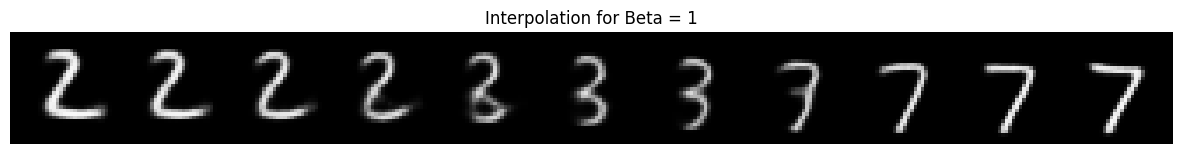

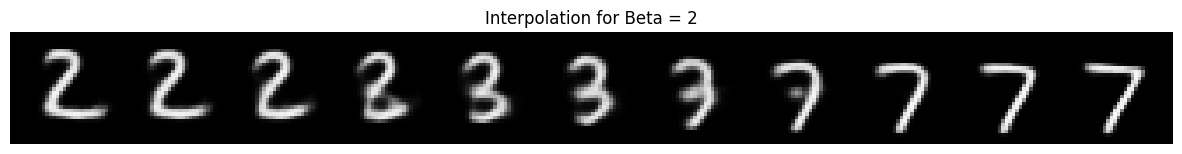

In [259]:
# # CODE FOR PART 1.3b IN THIS CELL

import matplotlib.pyplot as plt
import torchvision

# Function to show images
def show_images(images, nrow=5, title=""):
    images = torchvision.utils.make_grid(images, nrow=nrow)
    images = images.permute(1, 2, 0)
    plt.figure(figsize=(15, 15))
    plt.title(title)
    plt.imshow(images)
    plt.axis('off')
    plt.show()

# Ensure all models are in evaluation mode and plot for every beta
for beta in beta_values:
    model_path = content_path /'VAE/'f'VAE_model_beta_{beta}.pth'
    model = VAE(latent_dim).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Select two digits from the test set
    digit1, digit2 = None, None
    for images, labels in loader_test:
        index1 = (labels == 2).nonzero(as_tuple=True)[0][0]
        index2 = (labels == 7).nonzero(as_tuple=True)[0][0]
        digit1, digit2 = images[index1:index1+1], images[index2:index2+1]
        break

    # Encode the digits to obtain their latent representations
    with torch.no_grad():
        z1, _ = model.encode(digit1.to(device))
        z2, _ = model.encode(digit2.to(device))

    # Number of steps in the interpolation
    n_steps = 10
    interpolated = []

    # Perform interpolation
    for i in range(n_steps + 1):
        alpha = i / float(n_steps)
        z = (1 - alpha) * z1 + alpha * z2
        interpolated.append(z)

    # Stack all interpolated representations
    interpolated = torch.cat(interpolated, dim=0)

    with torch.no_grad():
        # Pass the interpolated latent vectors through the decoder
        reconstructions = model.decode(interpolated.to(device))

    # Plot for this beta
    show_images(reconstructions.cpu(), nrow=n_steps + 1, title=f"Interpolation for Beta = {beta}")


### Discussion

In the interpolation images above for different values of β (0.25, 0.5, 0.75, 1, and 2), we can observe how the transition between the digits is affected by the weighting of the KL divergence in the loss function.

1. **For β = 0.25**: The transition between the digits appears smooth, with clear intermediate stages. This suggests that the latent space allows for nuanced differences between digits, likely because the model is not heavily penalized for deviations from the prior distribution due to the lower β. This can lead to a more detailed and continuous latent space but may also risk less regularity.

2. **For β = 0.5 and 0.75**: The interpolation still maintains a level of smoothness, but we can start to see the structure being imposed on the latent space. The transitions are still understandable, implying that while the latent space is more regularized than at β = 0.25, it still captures a wide variety of features.

3. **For β = 1**: This represents the standard VAE, and the interpolation shows a balanced transition between the digits. The smoothness is expected because the loss function balances the reconstruction fidelity and the KL divergence equally, resulting in a latent space that is neither too loose nor too tight.

4. **For β = 2**: The interpolation shows more abrupt changes between digits, and the images may become less distinct. This can indicate a highly regularized latent space where the emphasis on the KL divergence has potentially led to a compromise in capturing the nuances of the digits. The reconstructions and transitions may not capture intermediate forms as well, leading to less detailed images.

Relating this to T-SNE visualization:
- T-SNE is a technique that reduces the dimensionality of data to two or three dimensions for visualization. It helps to understand the structure of the latent space by showing how different data points (in this case, digit representations) cluster together.
- For lower values of β, more dispersed clusters in T-SNE plots is observed because the model has more freedom to place similar digits closer in the latent space without strongly adhering to the prior distribution.
- As β increases, the T-SNE clusters become tighter and start to overlap more, reflecting the increased pressure on the latent space to match the prior distribution, potentially at the expense of distinctiveness between different types of digits.
- For β = 2, tightest clusters compared to lower beta is observed, as the model prioritizes the structure of the latent space heavily.

In summary, the interpolation images reflect the underlying structure of the latent space influenced by the value of β. A well-chosen β value allows for a latent space that supports both a good reconstruction quality and a meaningful organization of the latent variables, which would be reflected in smooth interpolations and well-separated clusters in T-SNE visualizations.

# Test
<font color="orange"> <b> Provide the input and output transformations required to make your VAE work </b></font>


In [ ]:
# If you want to run these tests yourself, change directory:
%cd 'dl/'
ta_data_path = "../data" # You can change this to = data_path when testing

In [4]:
!pip install -q torch torchvision

In [5]:
# Do not remove anything here
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt 

show = lambda img: plt.imshow(np.transpose(img.cpu().numpy(), (1,2,0)))

device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")

# Do not change this cell!
torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

In [6]:
############# CHANGE THESE (COPY AND PASTE FROM YOUR OWN CODE) #############
vae_transform = transforms.Compose([
    transforms.ToTensor(),
])

def vae_denorm(x):
    return x

mean_v3 = torch.Tensor([0.5,0.5,0.5])
std_v3 = torch.Tensor([0.5,0.5,0.5])
unnormalize_v3 = transforms.Normalize((-mean_v3 / std_v3).tolist(), (1.0 / std_v3).tolist())

def denorm_v3(x, channels=None, w=None ,h=None, resize = False):
    
    x = unnormalize_v3(x)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x
    
def gan_denorm(x):
    return denorm_v3(x)

gan_latent_size = 256

# If your generator requires something other than noise as input, please specify
# two cells down from here

In [7]:
# Load VAE Dataset
test_dat = datasets.MNIST(ta_data_path, train=False, transform=vae_transform, 
                          download=True)
vae_loader_test = DataLoader(test_dat, batch_size=32, shuffle=False)

In [8]:
############# MODIFY IF NEEDED #############
vae_input, _ = next(iter(vae_loader_test))

# If your generator is conditional, then please modify this input suitably
input_noise = torch.randn(100, gan_latent_size, 1, 1, device=device)
gan_input = [input_noise] # In case you want to provide a tuple, we wrap ours

Used CNN


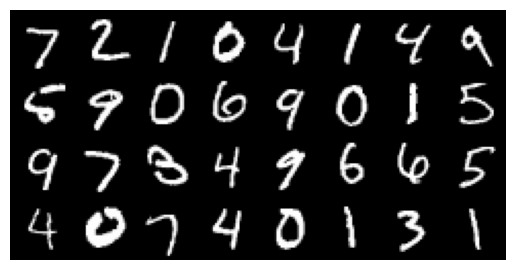

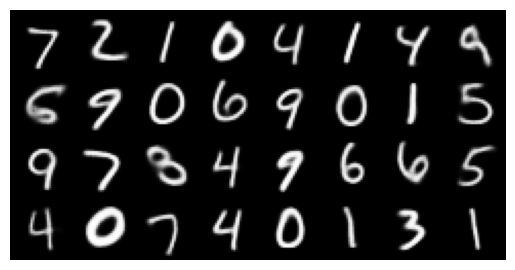

In [9]:
# VAE Tests

vae = model_G = torch.jit.load('./VAE/VAE_model.pth')
vae.eval()

# Check if VAE is convolutional
def recurse_cnn_check(parent, flag):
    if flag:
        return flag
    children = list(parent.children())
    if len(children) > 0:
        for child in children:
            flag = flag or recurse_cnn_check(child, flag)
    else:
        params = parent._parameters
        if 'weight' in params.keys():
            flag = params['weight'].ndim == 4
    return flag

has_cnn = recurse_cnn_check(vae, False)
print("Used CNN" if has_cnn else "Didn't Use CNN")

vae_in = make_grid(vae_denorm(vae_input), nrow=8, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure()
plt.axis('off')
show(vae_in)

vae_test = vae(vae_input.to(device))[0].detach()
vae_reco = make_grid(vae_denorm(vae_test), nrow=8, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure()
plt.axis('off')
show(vae_reco)